In [6]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt 
import time

config_file = 'configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py'
# download the checkpoint from model zoo and put it in `checkpoints/`
# url: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
checkpoint_file = 'laboro_tomato_big_48ep.pth'

load checkpoint from local path: laboro_tomato_big_48ep.pth


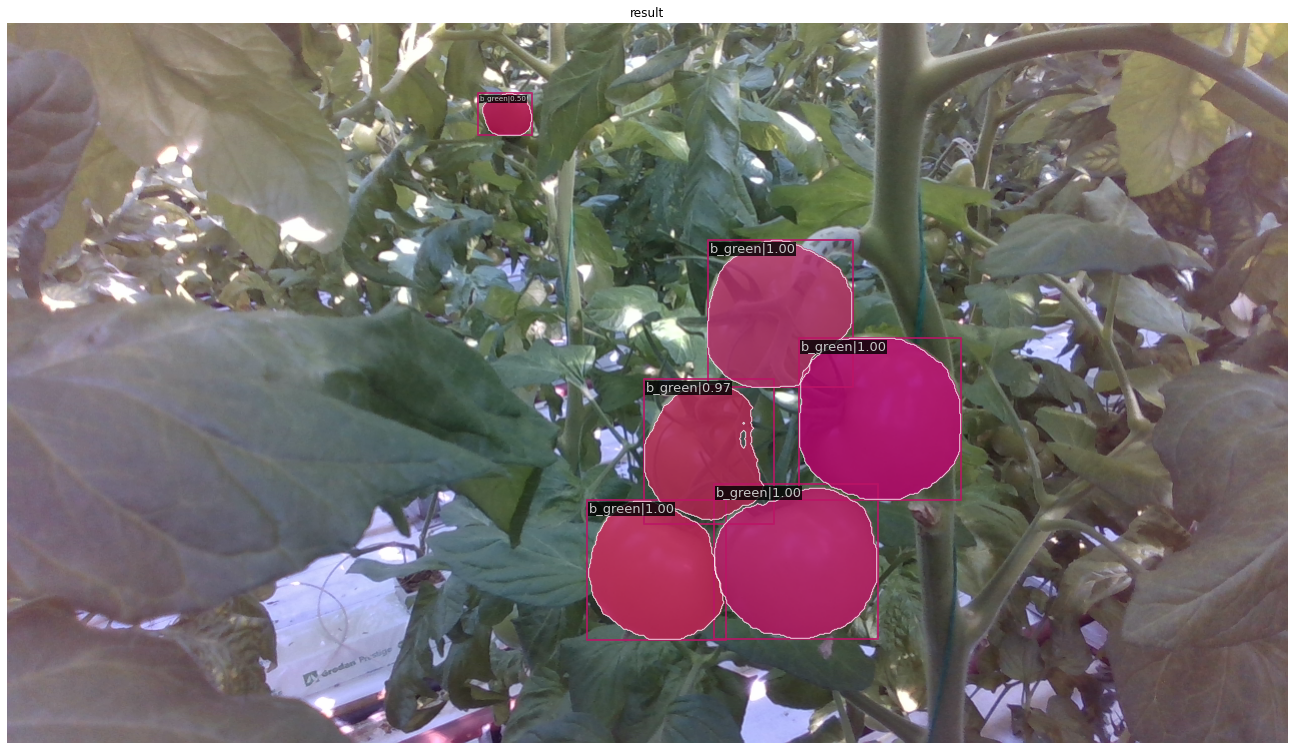

In [7]:
# build the model from a config file and a checkpoint file
img = mmcv.imread('image/1c085f5f04d4494087d1f7ca80da4f0f color.png')
model = init_detector(config_file, checkpoint_file, device='cpu')
depthData = np.load('image/1c085f5f04d4494087d1f7ca80da4f0f depthData.npy')
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

bbox_result, segm_result = result

labels = [
    np.full(bbox.shape[0], i, dtype=np.int32)\
    for i, bbox in enumerate(bbox_result)
]
labels = np.concatenate(labels)
bboxes = np.vstack(bbox_result)
segm_result = [x for x in segm_result if x != []]
segment = np.vstack(segm_result)

In [8]:
import pyrealsense2 as rs
color_intrin = rs.pyrealsense2.intrinsics() #create a color intrinsics property
color_intrin.width = 1280
color_intrin.height = 720
color_intrin.ppx = 646.9525146484375
color_intrin.ppy = 375.3297119140625
color_intrin.fx = 911.9494018554688
color_intrin.fy = 912.0560302734375
color_intrin.model = rs.pyrealsense2.distortion.inverse_brown_conrady
color_intrin.coeffs = [0.0, 0.0, 0.0, 0.0, 0.0]

In [9]:
# Calculating the fruit radius
import math
height = []
width = []
perPixelFOV_Radians_X = 1.50098/1280
perPixelFOV_Radians_Y = 0.994838/720

start = time.clock()

for bbox in bboxes:
    xMin = int(bbox[0])
    xMax = int(bbox[2])
    yMin = int(bbox[1])
    yMax = int(bbox[3])
    xMid = int((xMin + xMax)/2)
    yMid = int((yMin + yMax)/2)
    
    top = [xMid, yMin]
    bot = [xMid, yMax]
    left = [xMin, yMid]
    right = [xMax, yMid]
    center = [xMid, yMid]
    
    fruitRadiusinPixelsX = xMid - xMin
    fruitRadiusinPixelsY = yMid - yMin
    centerDepth = depthData[yMid, xMid]
    
    result = rs.rs2_deproject_pixel_to_point(color_intrin, center, centerDepth)
    #distance = np.linalg.norm(result)

    FRUIT_RADIUSx = 200*(centerDepth)*math.tan(perPixelFOV_Radians_X*fruitRadiusinPixelsX)
    FRUIT_RADIUSy = 200*(centerDepth)*math.tan(perPixelFOV_Radians_Y*fruitRadiusinPixelsY)
    
    height.append(FRUIT_RADIUSy)
    width.append(FRUIT_RADIUSx)
end = time.clock()
print(height)
print(width)
print(end - start)

[6.706767283364701, 6.519952458208461, 7.035547274810185, 6.639309330365032, 6.847193037125752, 4.980562270044996]
[6.057310671921557, 5.44919722583138, 5.96393822365529, 5.551814563231513, 5.238954504874338, 5.43489496666686]
0.00042270000000144137


C:\Users\skwe9\miniconda3\envs\open-mmlab\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
C:\Users\skwe9\miniconda3\envs\open-mmlab\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [10]:
from PIL import Image
height = []
width = []
count = 0

start = time.clock()

for bbox in bboxes:
    mask = np.asarray(segment[count], dtype="uint8") #binary matrix

    # Find contours
    cnts = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv.contourArea)

    # Obtain outer coordinates
    left = tuple(c[c[:, :, 0].argmin()][0])
    right = tuple(c[c[:, :, 0].argmax()][0])
    top = tuple(c[c[:, :, 1].argmin()][0])
    bottom = tuple(c[c[:, :, 1].argmax()][0])
    
    xMin = int(bbox[0])
    xMax = int(bbox[2])
    yMin = int(bbox[1])
    yMax = int(bbox[3])
    xMid = int((xMin + xMax)/2)
    yMid = int((yMin + yMax)/2)
    center = [xMid, yMid]
    
    fruitRadiusinPixelsX = xMid - left[0]
    fruitRadiusinPixelsY = yMid - top[1]
    centerDepth = depthData[yMid, xMid]
    
    result = rs.rs2_deproject_pixel_to_point(color_intrin, center, centerDepth)
    #distance = np.linalg.norm(result)

    FRUIT_RADIUSx = 200*(centerDepth)*math.tan(perPixelFOV_Radians_X*fruitRadiusinPixelsX)
    FRUIT_RADIUSy = 200*(centerDepth)*math.tan(perPixelFOV_Radians_Y*fruitRadiusinPixelsY)
    
    height.append(FRUIT_RADIUSy)
    width.append(FRUIT_RADIUSx)
    
    count = count + 1
end = time.clock()
print(end - start)
print(height)
print(width)

0.005997400000012476
[6.355924212803874, 6.4262393516490555, 7.035547274810185, 6.639309330365032, 6.368863846882394, 4.980562270044996]
[5.982992092649292, 5.290587874673259, 5.889872875444256, 5.551814563231513, 5.158049390746498, 4.427935462897946]


C:\Users\skwe9\miniconda3\envs\open-mmlab\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
C:\Users\skwe9\miniconda3\envs\open-mmlab\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


load checkpoint from local path: laboro_tomato_big_48ep.pth


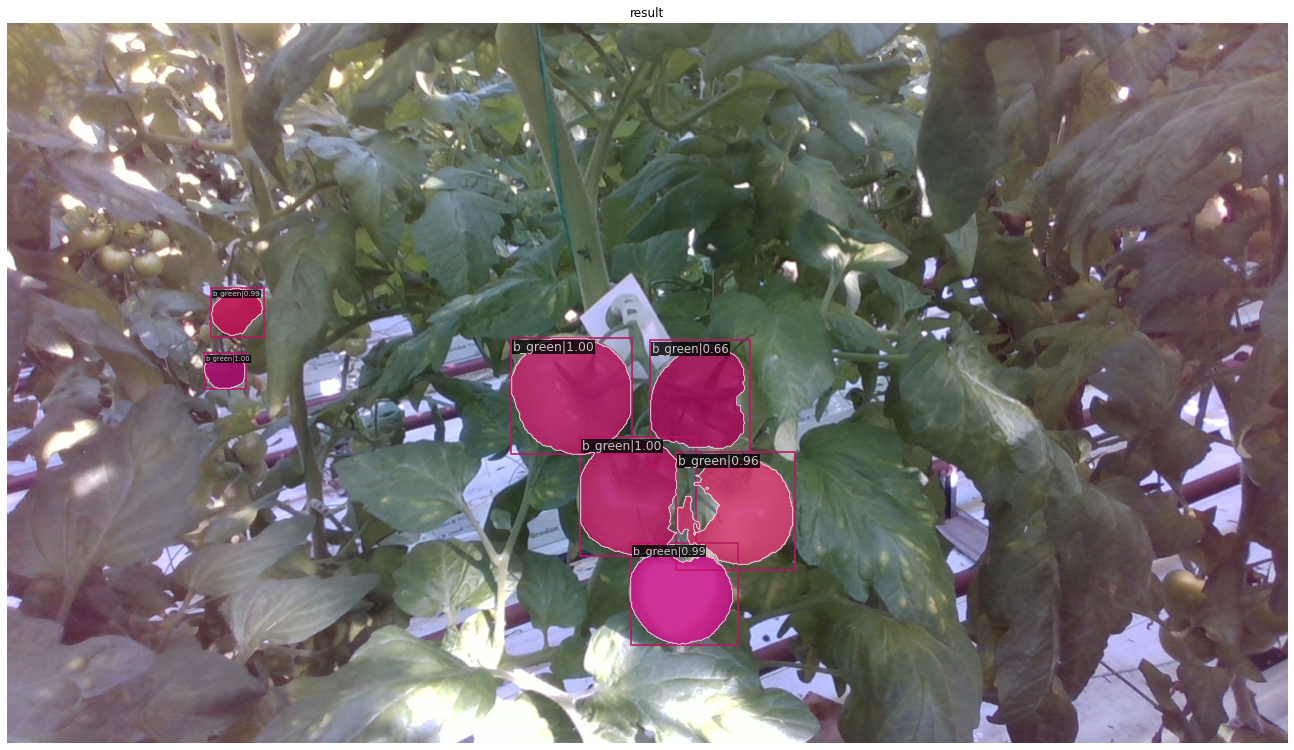

In [67]:
# build the model from a config file and a checkpoint file
img = mmcv.imread('image/83a1d79d46cf4f8a923bfbedc34f8a92 color.png')
model = init_detector(config_file, checkpoint_file, device='cpu')
depthData = np.load('image/83a1d79d46cf4f8a923bfbedc34f8a92 depthData.npy')
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

bbox_result, segm_result = result

labels = [
    np.full(bbox.shape[0], i, dtype=np.int32)\
    for i, bbox in enumerate(bbox_result)
]
labels = np.concatenate(labels)
bboxes = np.vstack(bbox_result)
segm_result = [x for x in segm_result if x != []]
segment = np.vstack(segm_result)

In [68]:
# Calculating the fruit radius
import math
height = []
width = []
perPixelFOV_Radians_X = 1.50098/1280
perPixelFOV_Radians_Y = 0.994838/720

for bbox in bboxes:
    xMin = int(bbox[0])
    xMax = int(bbox[2])
    yMin = int(bbox[1])
    yMax = int(bbox[3])
    xMid = int((xMin + xMax)/2)
    yMid = int((yMin + yMax)/2)
    
    top = [xMid, yMin]
    bot = [xMid, yMax]
    left = [xMin, yMid]
    right = [xMax, yMid]
    center = [xMid, yMid]
    
    fruitRadiusinPixelsX = xMid - xMin
    fruitRadiusinPixelsY = yMid - yMin
    centerDepth = depthData[yMid, xMid]
    
    result = rs.rs2_deproject_pixel_to_point(color_intrin, center, centerDepth)
    #distance = np.linalg.norm(result)

    FRUIT_RADIUSx = 200*(centerDepth)*math.tan(perPixelFOV_Radians_X*fruitRadiusinPixelsX)
    FRUIT_RADIUSy = 200*(centerDepth)*math.tan(perPixelFOV_Radians_Y*fruitRadiusinPixelsY)
    
    height.append(FRUIT_RADIUSy)
    width.append(FRUIT_RADIUSx)
print(height)
print(width)

[6.971058595647194, 7.05909781320816, 4.746356219808773, 5.886753012876825, 6.183527157120582, 7.05909781320816, 7.505122122189044]
[6.117209950500141, 5.8854145483534435, 4.699486712613775, 5.189990443645953, 5.684847349638311, 5.987208995085554, 5.04814078746703]


In [69]:
height = []
width = []
count = 0
for bbox in bboxes:
    mask = np.asarray(segment[count], dtype="uint8") #binary matrix

    # Find contours
    cnts = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv.contourArea)

    # Obtain outer coordinates
    left = tuple(c[c[:, :, 0].argmin()][0])
    right = tuple(c[c[:, :, 0].argmax()][0])
    top = tuple(c[c[:, :, 1].argmin()][0])
    bottom = tuple(c[c[:, :, 1].argmax()][0])
    
    xMin = int(bbox[0])
    xMax = int(bbox[2])
    yMin = int(bbox[1])
    yMax = int(bbox[3])
    xMid = int((xMin + xMax)/2)
    yMid = int((yMin + yMax)/2)
    center = [xMid, yMid]
    
    fruitRadiusinPixelsX = xMid - left[0]
    fruitRadiusinPixelsY = yMid - top[1]
    centerDepth = depthData[yMid, xMid]
    
    result = rs.rs2_deproject_pixel_to_point(color_intrin, center, centerDepth)
    #distance = np.linalg.norm(result)

    FRUIT_RADIUSx = 200*(centerDepth)*math.tan(perPixelFOV_Radians_X*fruitRadiusinPixelsX)
    FRUIT_RADIUSy = 200*(centerDepth)*math.tan(perPixelFOV_Radians_Y*fruitRadiusinPixelsY)
    
    height.append(FRUIT_RADIUSy)
    width.append(FRUIT_RADIUSx)
    
    count = count + 1

print(height)
print(width)

[6.971058595647194, 6.818796527999461, 4.21880069083322, 4.614115456169092, 6.183527157120582, 6.338504604769514, 7.026416739431437]
[6.01492761070226, 5.783636362643142, 4.475617497993844, 5.189990443645953, 5.466071542382176, 5.783636362643142, 4.946953131063715]


load checkpoint from local path: laboro_tomato_big_48ep.pth


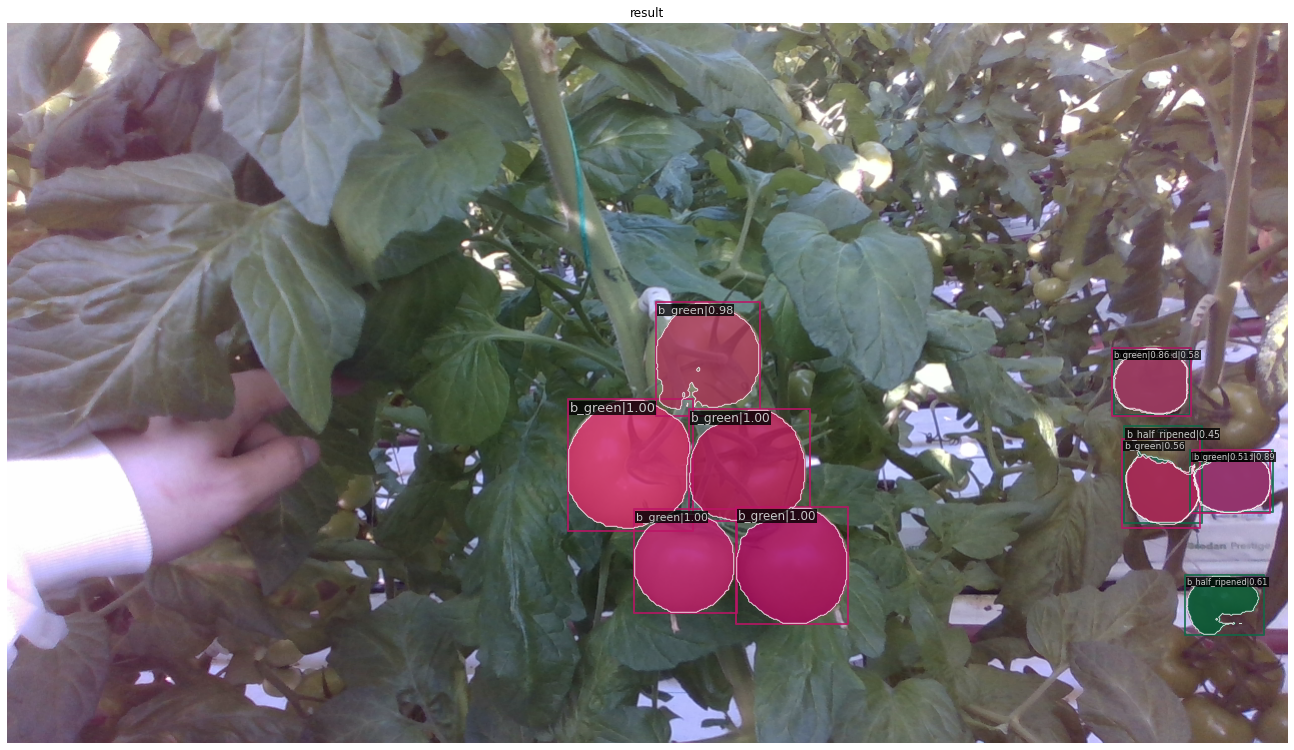

In [70]:
# build the model from a config file and a checkpoint file
img = mmcv.imread('image/374a7430eca74a89b741a537b8f30e15 color.png')
model = init_detector(config_file, checkpoint_file, device='cpu')
depthData = np.load('image/374a7430eca74a89b741a537b8f30e15 depthData.npy')
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

bbox_result, segm_result = result

labels = [
    np.full(bbox.shape[0], i, dtype=np.int32)\
    for i, bbox in enumerate(bbox_result)
]
labels = np.concatenate(labels)
bboxes = np.vstack(bbox_result)
segm_result = [x for x in segm_result if x != []]
segment = np.vstack(segm_result)

In [71]:
# Calculating the fruit radius
import math
height = []
width = []
perPixelFOV_Radians_X = 1.50098/1280
perPixelFOV_Radians_Y = 0.994838/720

for bbox in bboxes:
    xMin = int(bbox[0])
    xMax = int(bbox[2])
    yMin = int(bbox[1])
    yMax = int(bbox[3])
    xMid = int((xMin + xMax)/2)
    yMid = int((yMin + yMax)/2)
    
    top = [xMid, yMin]
    bot = [xMid, yMax]
    left = [xMin, yMid]
    right = [xMax, yMid]
    center = [xMid, yMid]
    
    fruitRadiusinPixelsX = xMid - xMin
    fruitRadiusinPixelsY = yMid - yMin
    centerDepth = depthData[yMid, xMid]
    
    result = rs.rs2_deproject_pixel_to_point(color_intrin, center, centerDepth)
    #distance = np.linalg.norm(result)

    FRUIT_RADIUSx = 200*(centerDepth)*math.tan(perPixelFOV_Radians_X*fruitRadiusinPixelsX)
    FRUIT_RADIUSy = 200*(centerDepth)*math.tan(perPixelFOV_Radians_Y*fruitRadiusinPixelsY)
    
    height.append(FRUIT_RADIUSy)
    width.append(FRUIT_RADIUSx)
print(height)
print(width)

[6.986101813598702, 7.548512248937308, 7.866330990458677, 11.118699555051531, 5.916205774975565, 6.5281173899811265, 7.516953761152305, 6.56949983916188, 6.629385604800902, 8.105050575704048, 10.116705548976656, 6.986101813598702, 7.8004323769917905]
[7.842801708538311, 8.329211070550429, 7.687292390055274, 7.661043481753251, 4.921813371307946, 5.933975816261846, 5.986797994651003, 5.3793669482116275, 5.128452289259743, 7.88986828245478, 7.606125769631309, 7.4596783554527795, 8.329211070550429]


In [72]:
height = []
width = []
count = 0
for bbox in bboxes:
    mask = np.asarray(segment[count], dtype="uint8") #binary matrix

    # Find contours
    cnts = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv.contourArea)

    # Obtain outer coordinates
    left = tuple(c[c[:, :, 0].argmin()][0])
    right = tuple(c[c[:, :, 0].argmax()][0])
    top = tuple(c[c[:, :, 1].argmin()][0])
    bottom = tuple(c[c[:, :, 1].argmax()][0])
    
    xMin = int(bbox[0])
    xMax = int(bbox[2])
    yMin = int(bbox[1])
    yMax = int(bbox[3])
    xMid = int((xMin + xMax)/2)
    yMid = int((yMin + yMax)/2)
    center = [xMid, yMid]
    
    fruitRadiusinPixelsX = xMid - left[0]
    fruitRadiusinPixelsY = yMid - top[1]
    centerDepth = depthData[yMid, xMid]
    
    result = rs.rs2_deproject_pixel_to_point(color_intrin, center, centerDepth)
    #distance = np.linalg.norm(result)

    FRUIT_RADIUSx = 200*(centerDepth)*math.tan(perPixelFOV_Radians_X*fruitRadiusinPixelsX)
    FRUIT_RADIUSy = 200*(centerDepth)*math.tan(perPixelFOV_Radians_Y*fruitRadiusinPixelsY)
    
    height.append(FRUIT_RADIUSy)
    width.append(FRUIT_RADIUSx)
    
    count = count + 1

print(height)
print(width)

[6.309316171706059, 7.296620992963715, 7.866330990458677, 5.321687932265294, 5.3456519446317685, 6.4110897333157, 7.402441016238704, 6.455758729199167, 6.512610911656098, 7.866330990458677, 6.433179828361675, 6.309316171706059, 7.296620992963715]
[7.076637236137926, 7.901521004109266, 7.484737681086538, 7.0710025046002585, 4.825083480319103, 5.834757228751754, 5.889903855383452, 5.283037493629524, 5.0295903429165065, 7.484737681086538, 6.825083432380162, 6.885146189360558, 7.901521004109266]
